<a href="https://colab.research.google.com/github/dhyannn/predictive-analytics/blob/main/514_PAlab9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms

In [2]:
import pandas as pd

In [3]:
data = pd.read_csv("/content/Time-Series Analysis Dataset.csv")

<ipython-input-4-f9e670d2e5e4>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='icon', y='temperature', data=data, palette='coolwarm')


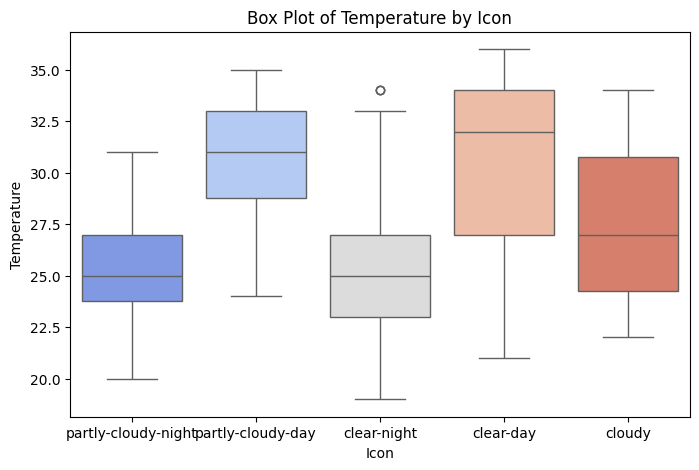

In [4]:
# Box Plot: Temperature
plt.figure(figsize=(8, 5))
sns.boxplot(x='icon', y='temperature', data=data, palette='coolwarm')
plt.title('Box Plot of Temperature by Icon')
plt.xlabel('Icon')
plt.ylabel('Temperature')
plt.show()

<ipython-input-5-bbb10a840718>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='icon', data=data, palette='viridis')


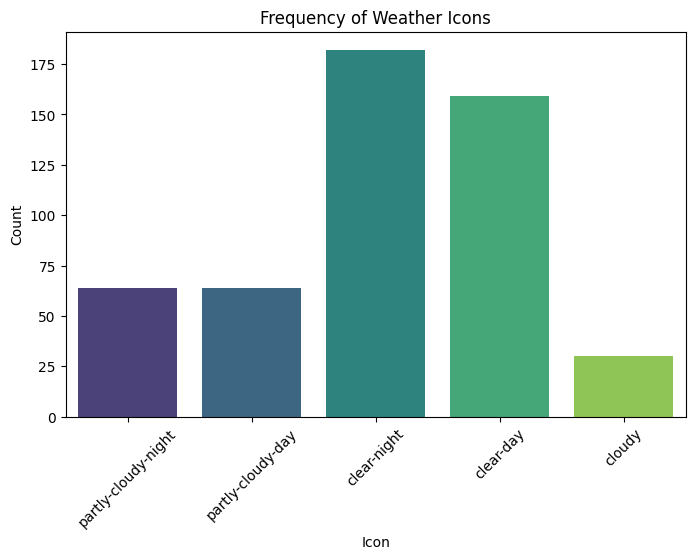

In [5]:
# Bar Plot: Categorical Icon Frequency
plt.figure(figsize=(8, 5))
sns.countplot(x='icon', data=data, palette='viridis')
plt.title('Frequency of Weather Icons')
plt.xlabel('Icon')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [6]:
if data.isna().any().any():
    print(data.isna().sum())  # Check which columns have NaN
    data = data.dropna()  # Drop all rows with NaN values (optional)

datetime_local      149
temperature         149
humidity            149
dew_point           149
wind_bearing        149
wind_speed          149
wind_gust           149
pressure            149
uv_index            149
ozone               149
precip_intensity    149
icon                149
dtype: int64


In [7]:
cleaned_data = data.dropna()

In [8]:
data = data.dropna(subset=['temperature'])

In [9]:
# Preprocessing
data['datetime_local'] = pd.to_datetime(data['datetime_local'], format='%d-%m-%Y %H:%M')
data['hour'] = data['datetime_local'].dt.hour
data['day'] = data['datetime_local'].dt.day

In [10]:
# Encode categorical variables
ohe = OneHotEncoder()
icon_encoded = ohe.fit_transform(data[['icon']]).toarray()
icon_columns = ohe.get_feature_names_out(['icon'])
icon_df = pd.DataFrame(icon_encoded, columns=icon_columns)

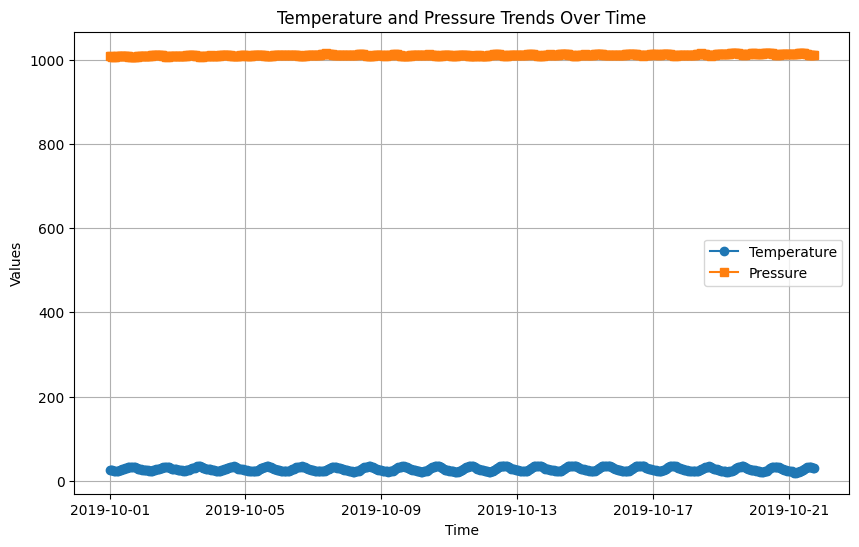

In [11]:
# Line Plot: Trends Over Time
plt.figure(figsize=(10, 6))
plt.plot(data['datetime_local'], data['temperature'], label='Temperature', marker='o')
plt.plot(data['datetime_local'], data['pressure'], label='Pressure', marker='s')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Temperature and Pressure Trends Over Time')
plt.legend()
plt.grid(True)
plt.show()

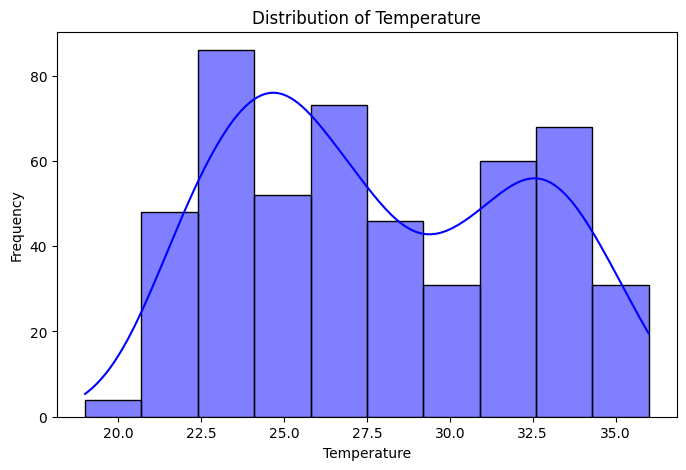

In [12]:
# Distribution Plot: Temperature
plt.figure(figsize=(8, 5))
sns.histplot(data['temperature'], kde=True, bins=10, color='blue')
plt.title('Distribution of Temperature')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()

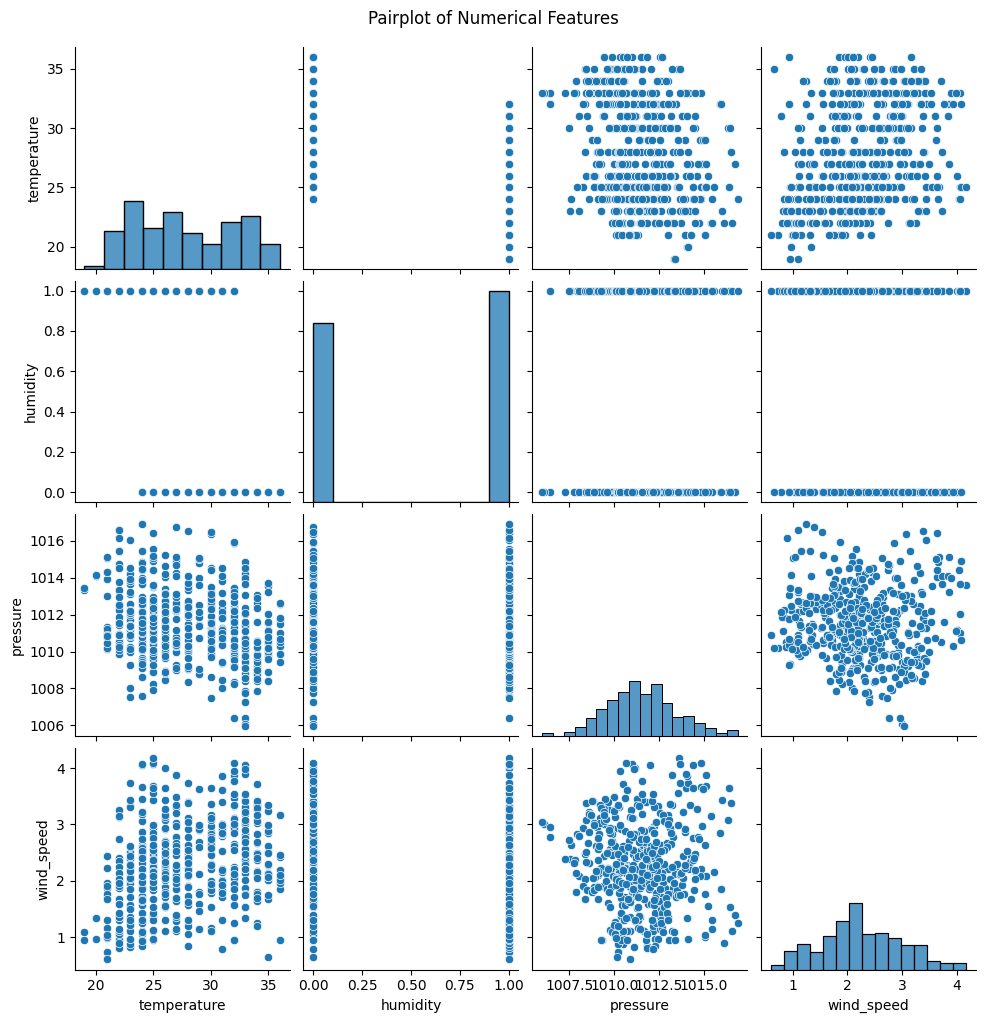

In [13]:

# Pairplot: Pairwise Relationships
sns.pairplot(data[['temperature', 'humidity', 'pressure', 'wind_speed']])
plt.suptitle('Pairplot of Numerical Features', y=1.02)
plt.show()

<ipython-input-14-f9e670d2e5e4>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='icon', y='temperature', data=data, palette='coolwarm')


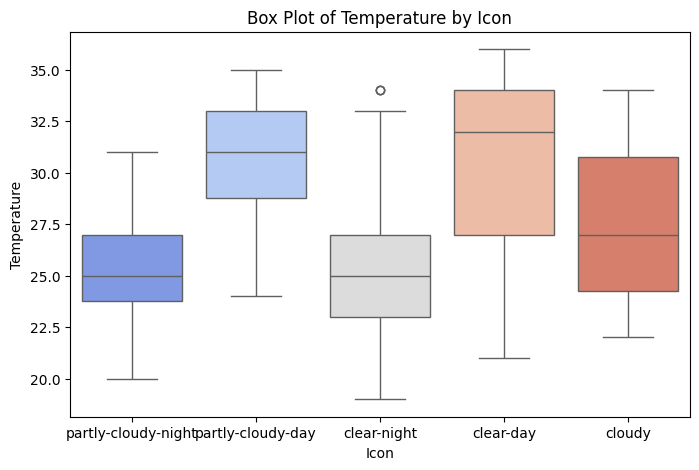

In [14]:
# Box Plot: Temperature
plt.figure(figsize=(8, 5))
sns.boxplot(x='icon', y='temperature', data=data, palette='coolwarm')
plt.title('Box Plot of Temperature by Icon')
plt.xlabel('Icon')
plt.ylabel('Temperature')
plt.show()

In [15]:
# Merge and normalize
data = pd.concat([data.drop(columns=['datetime_local', 'icon']), icon_df], axis=1)
scaler = MinMaxScaler()
data[data.columns] = scaler.fit_transform(data)

In [16]:
from sklearn.model_selection import train_test_split

# Split data
X = data.drop(columns=['temperature'])
y = data['temperature']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Impute or drop NaN values in y_train and y_test
y_train = y_train.fillna(y_train.mean())  # Example: Filling NaN with mean
y_test = y_test.fillna(y_test.mean())    # Example: Filling NaN with mean


In [17]:
# Genetic Algorithm setup
def evaluate(individual):
    n_estimators, max_depth = individual
    model = RandomForestRegressor(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        random_state=42
    )
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    return mean_squared_error(y_test, predictions),

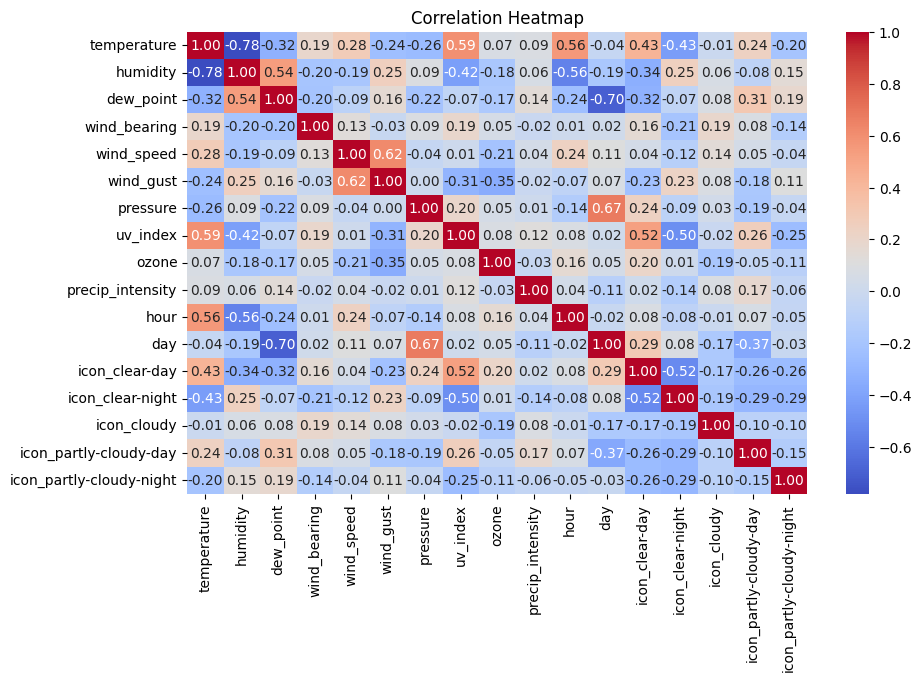

In [18]:
# Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

In [19]:
# Genetic Algorithm configuration
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox = base.Toolbox()
toolbox.register("attr_int", np.random.randint, 50, 200)  # n_estimators
toolbox.register("attr_depth", np.random.randint, 2, 20)  # max_depth
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_int, toolbox.attr_depth), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

In [20]:
# Run Genetic Algorithm
population = toolbox.population(n=10)
ngen, cxpb, mutpb = 20, 0.5, 0.2
result = algorithms.eaSimple(population, toolbox, cxpb, mutpb, ngen, verbose=False)

In [21]:
# Extract best model
best_ind = tools.selBest(population, k=1)[0]
best_model = RandomForestRegressor(
    n_estimators=int(best_ind[0]),
    max_depth=int(best_ind[1]),
    random_state=42
)
best_model.fit(X_train, y_train)
predictions = best_model.predict(X_test)

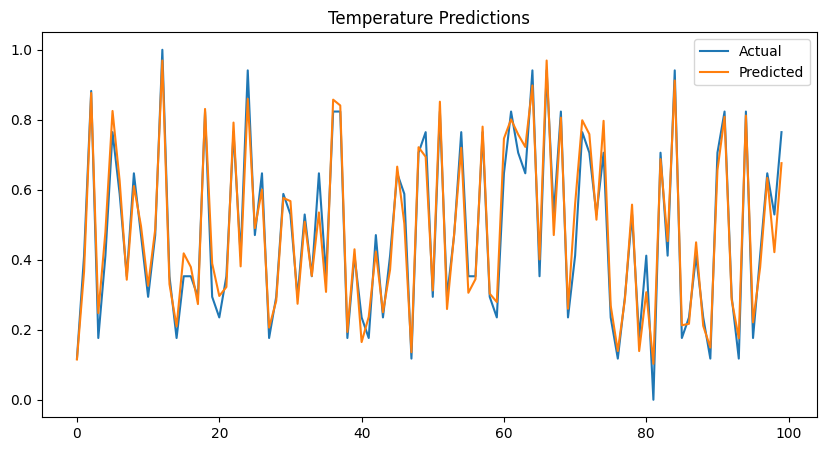

In [22]:
# Visualization
plt.figure(figsize=(10, 5))
plt.plot(range(len(y_test)), y_test, label='Actual')
plt.plot(range(len(y_test)), predictions, label='Predicted')
plt.legend()
plt.title('Temperature Predictions')
plt.show()

# Implementing GA with random forest

In [24]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error


In [26]:
from deap import base, creator, tools, algorithms
import random

# Define evaluation function (maximize R2 score)
def evaluate_hyperparameters(individual):
    # Extract hyperparameters
    n_estimators = max(1, int(individual[0]))  # Ensure n_estimators is >= 1
    max_depth = int(individual[1]) if individual[1] > 0 else None  # Convert -1 to None for unlimited depth

    # Train a Random Forest model with given hyperparameters
    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate R2 score (higher is better)
    r2 = r2_score(y_test, y_pred)
    return r2,

# Define Genetic Algorithm components
creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # Maximize R2
creator.create("Individual", list, fitness=creator.FitnessMax)
toolbox = base.Toolbox()

# Hyperparameter ranges
toolbox.register("attr_n_estimators", random.randint, 10, 200)  # Number of trees
toolbox.register("attr_max_depth", random.randint, -1, 50)     # -1 means unlimited depth

# Individual and population
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_n_estimators, toolbox.attr_max_depth), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Genetic operators
toolbox.register("mate", tools.cxBlend, alpha=0.5)  # Crossover
toolbox.register("mutate", tools.mutUniformInt, low=[10, -1], up=[200, 50], indpb=0.2)  # Mutation
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate_hyperparameters)

# Initialize population
population = toolbox.population(n=20)  # Population of 20 individuals

# Run Genetic Algorithm
n_gen = 10  # Number of generations
for gen in range(n_gen):
    offspring = algorithms.varAnd(population, toolbox, cxpb=0.5, mutpb=0.2)
    fits = map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    population = toolbox.select(offspring, k=len(population))

# Extract best individual (hyperparameters)
best_ind = tools.selBest(population, k=1)[0]
best_n_estimators, best_max_depth = int(best_ind[0]), int(best_ind[1])

# Train final model with best hyperparameters
model_ga = RandomForestRegressor(n_estimators=best_n_estimators, max_depth=best_max_depth, random_state=42)
model_ga.fit(X_train, y_train)
y_pred_ga = model_ga.predict(X_test)

# Evaluate accuracy with GA
mae_ga = mean_absolute_error(y_test, y_pred_ga)
r2_ga = r2_score(y_test, y_pred_ga)
rmse_ga = np.sqrt(mean_squared_error(y_test, y_pred_ga))

print("\nWith GA:")
print(f"Best n_estimators: {best_n_estimators}")
print(f"Best max_depth: {best_max_depth}")
print(f"Mean Absolute Error (MAE): {mae_ga}")
print(f"R-squared (R2): {r2_ga}")
print(f"Root Mean Squared Error (RMSE): {rmse_ga}")


/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "



With GA:
Best n_estimators: 231
Best max_depth: 66
Mean Absolute Error (MAE): 0.03853577794754251
R-squared (R2): 0.9619147342789195
Root Mean Squared Error (RMSE): 0.0478133610354391


# Without GA

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import numpy as np

# Prepare features (X) and target (y)
X = data.drop(columns=['temperature'])
y = data['temperature']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Regressor
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate accuracy
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Without GA:")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


Without GA:
Mean Absolute Error (MAE): 0.038700000000000005
R-squared (R2): 0.9611376213424335
Root Mean Squared Error (RMSE): 0.048298702942028905


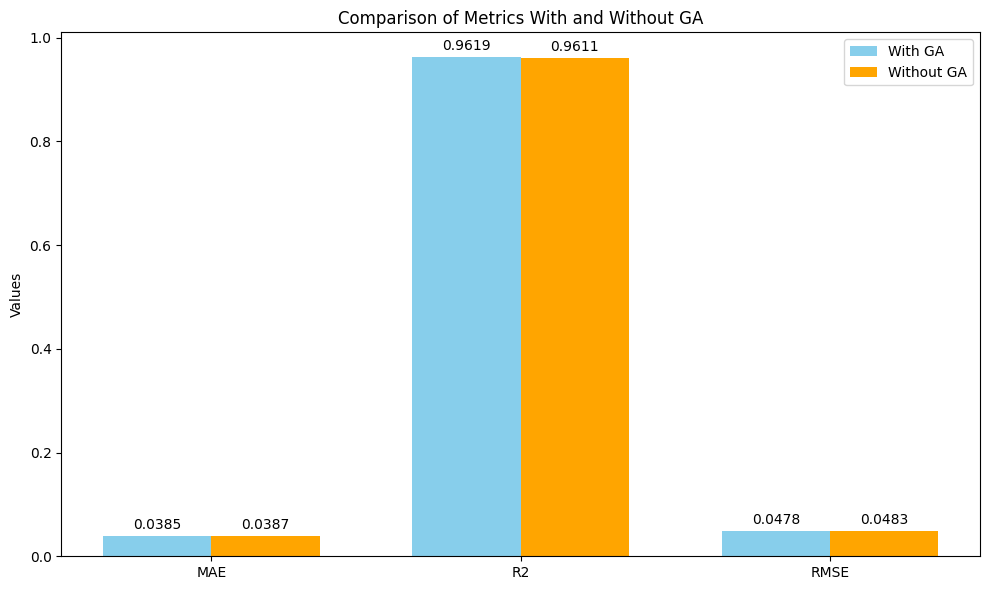

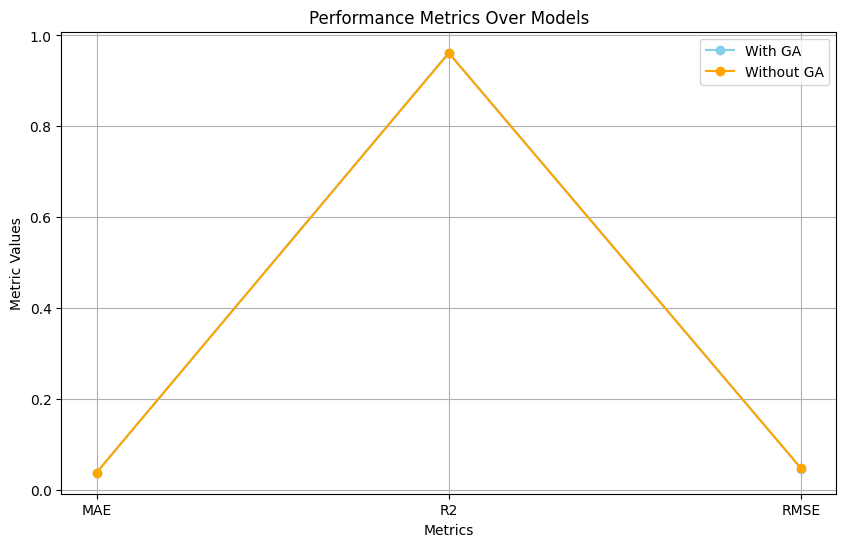

In [29]:
# Metrics with and without GA
metrics = ['MAE', 'R2', 'RMSE']
values_with_ga = [0.03853577794754251, 0.9619147342789195, 0.0478133610354391]
values_without_ga = [0.038700000000000005, 0.9611376213424335, 0.048298702942028905]

# Bar Chart for Metrics Comparison
x = np.arange(len(metrics))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, values_with_ga, width, label='With GA', color='skyblue')
bars2 = ax.bar(x + width/2, values_without_ga, width, label='Without GA', color='orange')

# Add labels, title, and legend
ax.set_ylabel('Values')
ax.set_title('Comparison of Metrics With and Without GA')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Add value annotations
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Line Plot for Predictions Comparison
y_pred_ga = [0.03853577794754251, 0.9619147342789195, 0.0478133610354391]  # Example predicted values
y_pred_no_ga = [0.038700000000000005, 0.9611376213424335, 0.048298702942028905]  # Example predicted values

plt.figure(figsize=(10, 6))
plt.plot(metrics, values_with_ga, marker='o', label='With GA', color='skyblue')
plt.plot(metrics, values_without_ga, marker='o', label='Without GA', color='orange')

plt.title('Performance Metrics Over Models')
plt.ylabel('Metric Values')
plt.xlabel('Metrics')
plt.legend()
plt.grid(True)
plt.show()